In [1]:
# This file costructs surrogate models for the input datasets
import numpy as np   
import pandas as pd
import os
import shutil
import json
import math
import time
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed, dump

# Torch specific module imports
import torch
import gpytorch 

# botorch specific modules
from botorch.fit import fit_gpytorch_model
from botorch.models.gpytorch import GPyTorchModel
from botorch.optim import optimize_acqf, optimize_acqf_discrete
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import (
    qExpectedImprovement,
    qNoisyExpectedImprovement,
)
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Tick parameters
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['legend.fontsize'] = 15

# User defined python classes and files
import input_class 
import code_inputs as model_input
import utils_dataset as utilsd
import surrogate_models
import kmeans as km

# Set the random seeds
np.random.seed(0)
torch.manual_seed(0)

Using cpu device


#### K means clustering

In [2]:
Input = input_class.inputs(input_path='../')
XX_prop, YY, descriptors = Input.read_inputs()
descriptors

['dimensions',
 ' bond type',
 ' void fraction [widom]',
 ' supercell volume [A^3]',
 ' density [kg/m^3]',
 ' heat desorption high P [kJ/mol]',
 ' absolute methane uptake high P [molec/unit cell]',
 ' absolute methane uptake high P [mol/kg]',
 ' excess methane uptake high P [molec/unit cell]',
 ' excess methane uptake high P [mol/kg]',
 ' heat desorption low P [kJ/mol]',
 ' absolute methane uptake low P [molec/unit cell]',
 ' absolute methane uptake low P [mol/kg]',
 ' excess methane uptake low P [molec/unit cell]',
 ' excess methane uptake low P [mol/kg]',
 ' surface area [m^2/g]',
 ' linkerA',
 ' linkerB',
 ' net',
 ' cell_a [A]',
 ' cell_b [A]',
 ' cell_c [A]',
 ' alpha [deg]',
 ' beta [deg]',
 ' gamma [deg]',
 ' num carbon',
 ' num fluorine',
 ' num hydrogen',
 ' num nitrogen',
 ' num oxygen',
 ' num sulfur',
 ' num silicon',
 ' vertices',
 ' edges',
 ' genus',
 ' largest included sphere diameter [A]',
 ' largest free sphere diameter [A]',
 ' largest included sphere along free sphe

In [3]:
XX_comp_df, YY_df = Input.get_comp()
XX_comp_df

,num carbon,num fluorine,num hydrogen,num nitrogen,num oxygen,num sulfur,num silicon
0,360,0,216,144,72,0,0
1,360,0,216,144,144,0,0
2,432,0,360,144,72,0,0
3,360,0,144,216,216,0,0
4,360,0,144,216,216,0,0
...,...,...,...,...,...,...,...
69835,996,0,576,96,0,0,0
69836,1020,0,576,48,0,0,0
69837,1360,0,768,64,0,0,0
69838,1888,0,1152,128,128,0,0


In [6]:
num_cluster = 1
clustered_dfs = km.k_means(XX_comp_df, YY_df, num_cluster)
sample_dfs = km.draw_samples(clustered_dfs, sample_fraction = 1.00)
samples = km.concat(sample_dfs)
samples

,num carbon,num fluorine,num hydrogen,num nitrogen,num oxygen,num sulfur,num silicon,deliverable capacity [v STP/v]
0,246,0,156,36,24,0,0,118.707728
1,576,0,512,128,0,0,0,170.133088
2,656,0,320,64,64,0,0,137.350112
3,576,0,360,0,0,0,0,92.034339
4,936,0,648,144,0,0,0,147.296600
...,...,...,...,...,...,...,...,...
69835,1248,0,576,320,0,0,0,143.719775
69836,1504,0,1280,256,192,0,0,101.241397
69837,752,0,544,160,0,0,0,105.661907
69838,440,0,320,64,64,0,0,132.487553


In [7]:
cluster_idx = 0
XX_desc = list(sample_dfs[cluster_idx].columns[:-1])
YY_desc = sample_dfs[cluster_idx].columns[-1]
print(sample_dfs[cluster_idx][XX_desc].to_numpy())
print('\n')
print(sample_dfs[cluster_idx][YY_desc].to_numpy())

[[246   0 156 ...  24   0   0]
 [576   0 512 ...   0   0   0]
 [656   0 320 ...  64   0   0]
 ...
 [752   0 544 ...   0   0   0]
 [440   0 320 ...  64   0   0]
 [504   0 288 ...  72   0   0]]


[118.70772784 170.13308797 137.35011199 ... 105.66190747 132.48755321
 113.54714269]


#### Acquisition function 

In [8]:
## TODO: TO BE Check
bounds = torch.tensor([[-10.0], [12.0]])

batch_size = 1
num_restarts= 10 
raw_samples = 512

def optimize_acqf_and_get_observation(acq_func, X_test, Y_test):
    """Optimizes the acquisition function, and returns a new candidate"""
    # print(X_test)
    # print(Y_test)
    # optimize
    candidates, _ = optimize_acqf_discrete(
        acq_function=acq_func,
        choices=X_test,
        q=batch_size,
        max_batch_size=2048,
        num_restarts=num_restarts,
        raw_samples=raw_samples,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        unique=True
    )
    
    print(candidates)
    # observe new values
    new_x = candidates.detach()
    b = [1 if torch.all(X_test[i].eq(new_x)) else 0 for i in range(0,X_test.shape[0]) ]
    b = torch.tensor(b).to(torch.int)
    index = b.nonzero()[0][0]
    new_y = torch.reshape(Y_test[0,index],(1,1))
    
    X_test_new = X_test[torch.arange(0, X_test.shape[0]) != index, ...]
    Y_test_new = Y_test[..., torch.arange(0, Y_test.shape[1]) != index]
    # X_test_new = X_test
    # Y_test_new = Y_test
    print(X_test_new)
    print(Y_test_new)
    
    return new_x, new_y, index, X_test_new, Y_test_new

#### GP Train Function

In [9]:
def create_train_test_data(cluster_dataXX, cluster_dataYY, random_seed):
    if model_input.standardize_data:
        cluster_dataXX, scalerX_transform = utilsd.standardize_data(cluster_dataXX)
        cluster_dataYY, scalerY_transform = utilsd.standardize_data(cluster_dataYY.reshape(-1,1))
    else:
        scalerX_transform = None
        scalerY_transform = None
    
    ## TODO : Incase for feature selection
        # ....
        # ....
        # ....

    # Create train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(cluster_dataXX, cluster_dataYY, test_size=model_input.test_size, random_state=random_seed)

    # Convert to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    Y_train = np.transpose(Y_train) # IMP : Has to have only one row for GP training
    Y_train = torch.tensor(Y_train, dtype=torch.float32)
    Y_test = np.transpose(Y_test)
    Y_test = torch.tensor(Y_test, dtype=torch.float32)

    return X_train, X_test, Y_train, Y_test, scalerX_transform, scalerY_transform

def train_gp(X_train, X_test, Y_train, Y_test, model=None):
    best_observed = []
    # Finding best value in initial data
    if model_input.maximization:
        best_observed_value = Y_train.max()
        optimal_solution = torch.cat([Y_train[0],Y_test[0]]).max()
    else:
        best_observed_value = Y_train.min()
        optimal_solution = torch.cat([Y_train[0],Y_test[0]]).min()
    
    # If optimal value is present in the initial dataset sample remove it  
    if (best_observed_value.eq(optimal_solution)) and model_input.maximization:
        print('Max in training set, removing it before training models.')
        optimal_position = torch.argmax(Y_train)
        
        # Add max value to test/exploration set
        X_add_toTest = torch.reshape(X_train[optimal_position,:],(1,X_train.shape[1]))
        X_test = torch.cat([X_test,X_add_toTest])
        Y_add_toTest = torch.reshape(optimal_solution,(1,1))      
        Y_test = torch.cat((Y_test,Y_add_toTest),1)
        
        # Remove max value from training set
        X_train = X_train[torch.arange(0, X_train.shape[0]) != optimal_position, ...]
        Y_train = Y_train[..., torch.arange(0, Y_train.shape[1]) != optimal_position]
        
        # Update best observed value
        best_observed_value = Y_train.max()
        
    elif (best_observed_value.eq(optimal_solution)) and not model_input.maximization:
        print('Min in training set, removing it before training models.')
        optimal_position = torch.argmin(Y_train)
        
        # Add min value to test/exploration set
        X_add_toTest = torch.reshape(X_train[optimal_position,:],(1,X_train.shape[1]))
        X_test = torch.cat([X_test,X_add_toTest])
        Y_add_toTest = torch.reshape(optimal_solution,(1,1))      
        Y_test = torch.cat((Y_test,Y_add_toTest),1)
        
        # Remove min value from training set
        X_train = X_train[torch.arange(0, X_train.shape[0]) != optimal_position, ...]
        Y_train = Y_train[..., torch.arange(0, Y_train.shape[1]) != optimal_position]
        
        # Update best observed value
        best_observed_value = Y_train.min()
    
    # Initialize data for training gp-0 and gp-l models
    X_train0, Y_train0, X_test0, Y_test0 = X_train, Y_train, X_test, Y_test
            
    n_batch = model_input.n_batch_perTrial
    
    # Initialize likelihood, GP model and acquisition function for the models
    #--------------------------- GP-0 ---------------------------#
    likelihood_gp0 = gpytorch.likelihoods.GaussianLikelihood()
    if model is None:
        model_gp0 = surrogate_models.ExactGPModel(X_train0, Y_train0, likelihood_gp0) 
    else:
        model_gp0 = model
    AcqFunc_0 = ExpectedImprovement(model=model_gp0, best_f=best_observed_value, maximize=model_input.maximization)
    best_observed.append(best_observed_value)  # Appending to best_observed list for the given trial
    
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, n_batch + 1):
        # Time start of iteration and end
        t0 = time.monotonic()
        if ((iteration-1)%model_input.n_update==0):
            # fit the models every 10 iterations
            model_gp0, likelihood_gp0 = surrogate_models.train_surrogate_gp0(X_train0, Y_train0)
    
        # optimize and get new observation using acquisition function
        new_x0, new_y0, index, X_test_new0, Y_test_new0 = optimize_acqf_and_get_observation(AcqFunc_0, X_test0, Y_test0)
        
        # Update remaining choices tensor
        X_test0 = X_test_new0
        Y_test0 = Y_test_new0

        # Update training points
        X_train0 = torch.cat([X_train0, new_x0])
        Y_train0 = torch.cat([Y_train0[0], new_y0[0]])
        Y_train0 = torch.reshape(Y_train0,(1,Y_train0.shape[0]))

        # update progress
        if model_input.maximization:
            best_value_ei0 = Y_train0.max()
        elif not model_input.maximization:
            best_value_ei0 = Y_train0.min()
        best_observed.append(best_value_ei0)

        # AcqFunc_0 = UpperConfidenceBound(model_gp0, beta=0.1) 
        AcqFunc_0 = ExpectedImprovement(model=model_gp0, best_f=best_value_ei0, maximize=model_input.maximization)

        # Time end of iteration
        t1 = time.monotonic()
    
        if model_input.verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (GP-0) = ",
                f"({best_value_ei0:>4.2f}",
                end="",)
            print(f'Iteration time = {t1-t0:>4.2f}.')

    # t1 = time.monotonic()
    # print(f"time = {t1-t0:>4.2f}.")

    return best_observed, X_train0, X_test0, Y_train0, Y_test0, model_gp0 

#### Main Function

In [10]:
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Create a new directory if it does not exist
isExist = os.path.exists(model_input.output_folder)
if not isExist:
    os.makedirs(model_input.output_folder)
    print("The new directory is created!", model_input.output_folder)
    
# Commented out by NKT
# # Copy input parameters file to output folder
# shutil.copy2('surrogate_model_inputs.py',model_input.output_folder)
# Copy surrogate model file to output folder
shutil.copy2('surrogate_models.py',model_input.output_folder)

# Training a single GP for test
# a = train_gp(0)

# # Train the cluster of GP models in a parallel for loop
# best_observed_all_ei0 = Parallel(n_jobs=-1)(
#     delayed(train_gp)(i) for i in range(num_cluster)
# )

# Train each GP model sequentially first then apply the epsilon greed algorithm
for trial in range(1, model_input.n_trials + 1):
    t0 = time.monotonic()
    if model_input.random_seed == 'time':
        random_seed = int(t0)
    elif model_input.random_seed == 'iteration':
        random_seed = trial

    print(f"\n -------------------- Trial {trial:>2} of {model_input.n_trials} --------------------\n", end="")

    best_observed_all_clusters = []
    X_train_all_clusters = []
    X_test_all_clusters = []
    Y_train_all_clusters = []
    Y_test_all_clusters = []
    model_gps_all_clusters = []

    # Now train each GP model sequentially first 
    ## TODO : This part can be parallizable using joblib
    for cluster_idx in range(num_cluster):
        print(f"\n -------------------- Cluster {cluster_idx:>2} of {num_cluster} --------------------\n", end="")
        XX_desc = list(sample_dfs[cluster_idx].columns[:-1])
        YY_desc = sample_dfs[cluster_idx].columns[-1]
        # (
        #     X_train,
        #     X_test,
        #     Y_train,
        #     Y_test,
        #     scalerX, 
        #     scalerY
        # ) = create_train_test_data(sample_dfs[cluster_idx][XX_desc].to_numpy(), sample_dfs[cluster_idx][YY_desc].to_numpy(), random_seed)
        X_train, X_test, Y_train, Y_test, scalerX_transform, scalerY_transform = create_train_test_data(clustered_dfs[cluster_idx][XX_desc].to_numpy(), clustered_dfs[cluster_idx][YY_desc].to_numpy(), random_seed)
        dump(scalerX_transform, os.path.join(model_input.output_folder, f'scalerX_{cluster_idx}.joblib'))
        dump(scalerY_transform, os.path.join(model_input.output_folder, f'scalerY_{cluster_idx}.joblib'))
        (
            best_observed_idx, 
            X_train_idx,
            X_test_idx, 
            Y_train_idx, 
            Y_test_idx,
            model_gp_idx
        ) = train_gp(X_train, X_test, Y_train, Y_test)
        best_observed_all_clusters.append(best_observed_idx)
        X_train_all_clusters.append(X_train_idx)
        X_test_all_clusters.append(X_test_idx)
        Y_train_all_clusters.append(Y_train_idx)
        Y_test_all_clusters.append(Y_test_idx)
        model_gps_all_clusters.append(model_gp_idx)
    
    print(f'\n')
    print(f'Starting the epsilon greedy search')
    print(f'\n')

    # # Now apply the epsilon greedy algorithm and choose which GP to train next
    # for i in range(5):
    #     random_number = np.random.rand()
    #     epsilon = 0.1  # 10% exploration
    #     # Explore using the Epsilon Greedy Exploration Strategy
    #     if random_number <= epsilon:
    #         # Selecting a number between 1,2 and 3
    #         cluster_idx = np.random.choice(num_cluster)
    #     else:
    #         # Exploit best known action
    #         cluster_idx = np.argmax([best_observed_all_clusters[i][-1] for i in range(num_cluster)])
    #     print(f'Iteration {i} : Cluster {cluster_idx} is selected for training')
    #     (
    #         best_observed_idx,
    #         X_train_idx, 
    #         X_test_idx,
    #         Y_train_idx,
    #         Y_test_idx,
    #         model_gp_idx
    #     ) = train_gp(X_train_all_clusters[cluster_idx], \
    #                 X_test_all_clusters[cluster_idx], \
    #                 Y_train_all_clusters[cluster_idx], \
    #                 Y_test_all_clusters[cluster_idx], \
    #                 model=model_gps_all_clusters[cluster_idx])
        
    #     best_observed_all_clusters[cluster_idx].extend(best_observed_idx)
    #     X_train_all_clusters[cluster_idx] = X_train_idx
    #     X_test_all_clusters[cluster_idx] = X_test_idx
    #     Y_train_all_clusters[cluster_idx] = Y_train_idx
    #     Y_test_all_clusters[cluster_idx] = Y_test_idx
    #     model_gps_all_clusters[cluster_idx] = model_gp_idx



 -------------------- Trial  1 of 1 --------------------

 -------------------- Cluster  0 of 1 --------------------
tensor([[-0.4551, -0.0350, -1.0010,  1.2717,  0.2370, -0.0614, -0.1589]])
tensor([[-0.1315, -0.0350,  0.3236,  ..., -0.2423, -0.0614, -0.1589],
        [-0.4380, -0.0350, -0.1670,  ..., -0.2423, -0.0614, -0.1589],
        [-0.1485, -0.0350, -0.1180,  ...,  0.2370, -0.0614, -0.1589],
        ...,
        [-0.4551, -0.0350, -0.4859,  ..., -0.6258, -0.0614, -0.1589],
        [-0.7106, -0.0350, -0.7067,  ..., -0.6258, -0.0614, -0.1589],
        [-1.0171, -0.0350, -0.9274,  ..., -0.6258, -0.0614, -0.1589]])
tensor([[ 0.7023, -0.4456,  1.6468,  ..., -0.4606, -0.2699, -2.1043]])

Batch  1: best_value (GP-0) =  (2.59Iteration time = 174.28.
tensor([[-0.4551, -0.0350, -0.7803,  1.2717,  0.2370, -0.0614, -0.1589]])
tensor([[-0.1315, -0.0350,  0.3236,  ..., -0.2423, -0.0614, -0.1589],
        [-0.4380, -0.0350, -0.1670,  ..., -0.2423, -0.0614, -0.1589],
        [-0.1485, -0.0350, 

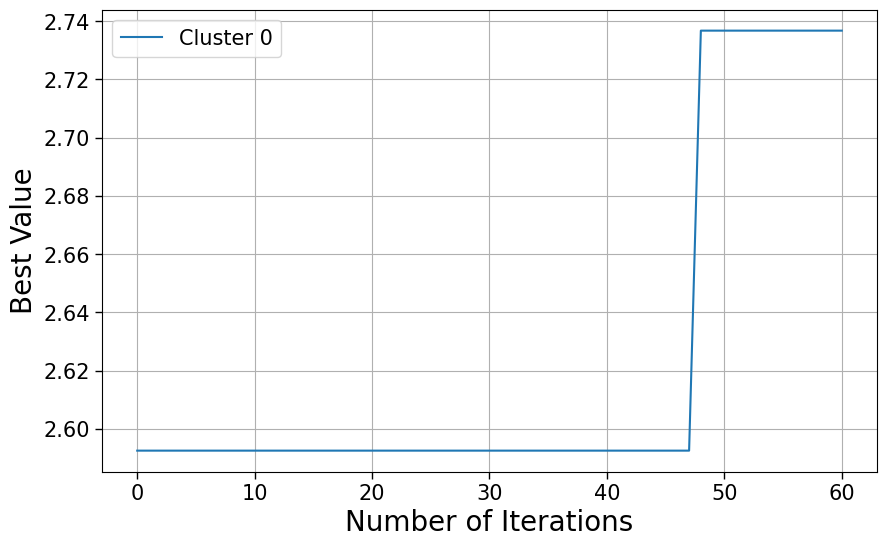

In [11]:
# Plot the best value obtained vs number of iterations
plt.figure(figsize=(10, 6))
for i in range(num_cluster):
    plt.plot(best_observed_all_clusters[i], label=f'Cluster {i}')
plt.xlabel('Number of Iterations')
plt.ylabel('Best Value')
plt.legend()
plt.grid()
plt.show()
